In [47]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy import stats

from scipy import ndimage
import numpy as np
import emd
from mne.decoding import SSD    

# Helper function for the second level sift
def mask_sift_second_layer(IA, masks, config={}):
    imf2 = np.zeros((IA.shape[0], IA.shape[1], config['max_imfs']))
    for ii in range(IA.shape[1]):
        config['mask_freqs'] = masks[ii:]
        tmp = emd.sift.mask_sift(IA[:, ii], **config)
        imf2[:, ii, :tmp.shape[1]] = tmp
    return imf2

def get_if_dist_trl(filename):
    raw=mne.io.read_raw_fif(filename)
    freqs_sig = 9, 12
    freqs_noise = 8, 13

    epochs = mne.make_fixed_length_epochs(raw, duration=2, preload=False)
    epochs.drop_bad(reject = dict(mag=3e-12))      # unit: T (magnetometers)

    ssd = SSD(info=raw.info,
              reg='oas',
              sort_by_spectral_ratio=False,  # False for purpose of example.
              n_components = 5,
              filt_params_signal=dict(l_freq=freqs_sig[0], h_freq=freqs_sig[1],
                                      l_trans_bandwidth=1, h_trans_bandwidth=1),
              filt_params_noise=dict(l_freq=freqs_noise[0], h_freq=freqs_noise[1],
                                     l_trans_bandwidth=1, h_trans_bandwidth=1))
    ssd.fit(X=epochs.get_data())

    pattern = mne.EvokedArray(data=ssd.patterns_[:4].T,
                              info=ssd.info)
    pattern.plot_topomap(units=dict(mag='A.U.'), time_format='')

    idx = np.argmax(np.abs(ssd.patterns_[0]))
    name_ = raw.info['ch_names'][idx]
    epochs.load_data()
    x = epochs.copy().pick_channels([name_]).get_data()
    x = np.squeeze(x) * 1e+15
    x.shape

    n_trl = epochs.get_data().shape[0]
    sholo_temp = np.zeros((n_trl, 256, 128))

    sample_rate = np.int(raw.info['sfreq'])
    config = emd.sift.get_config('mask_sift')
    config['max_imfs'] = 7
    config['mask_freqs'] = 50/sample_rate
    config['mask_amp_mode'] = 'ratio_sig'
    config['imf_opts/sd_thresh'] = 0.05

    # Carrier frequency histogram definition
    carrier_hist = (1, 100, 256, 'log')
    # AM frequency histogram definition
    am_hist = (1e-2, 32, 128, 'log')

    for n in range(n_trl):
        imf = emd.sift.mask_sift(x[n], **config)
        IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')
        masks = np.array([25/2**ii for ii in range(12)])/sample_rate
        config = emd.sift.get_config('mask_sift')
        config['mask_amp_mode'] = 'ratio_sig'
        config['mask_amp'] = 2
        config['max_imfs'] = 5
        config['imf_opts/sd_thresh'] = 0.05
        config['envelope_opts/interp_method'] = 'mono_pchip'

        # Sift the first 5 first level IMFs
        imf2 = emd.sift.mask_sift_second_layer(IA, masks, sift_args=config)

        IP2, IF2, IA2 = emd.spectra.frequency_transform(imf2, sample_rate, 'nht')
        fcarrier, fam, holo = emd.spectra.holospectrum(IF[:,0:6], IF2[:,0:6,:], IA2[:,0:6,:], carrier_hist, am_hist)
        sholo = ndimage.gaussian_filter(holo, 1)

        sholo_temp[n] = sholo
        pass

    sholo_m = np.squeeze(np.nanmean(sholo_temp, axis = 0))
    return sholo_m, fam, fcarrier


In [ ]:
%matplotlib qt

/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


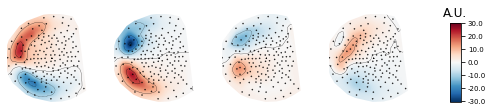

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_rate = np.int(raw.info['sfreq'])


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/numpy/lib/function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi
/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/emd/utils.py:297: RuntimeWarning: invalid value encountered in remainder
  phases = (IP) % (ncycles * 2 * np.pi)


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:89: RuntimeWarning: Mean of empty slice
  sholo_m = np.squeeze(np.nanmean(sholo_temp, axis = 0))
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


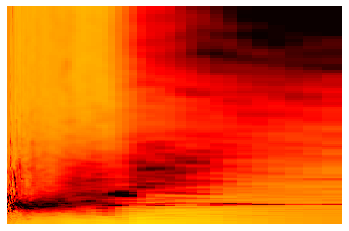

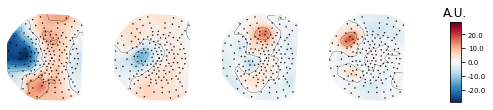

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_rate = np.int(raw.info['sfreq'])


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/numpy/lib/function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi
/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/emd/utils.py:297: RuntimeWarning: invalid value encountered in remainder
  phases = (IP) % (ncycles * 2 * np.pi)


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:89: RuntimeWarning: Mean of empty slice
  sholo_m = np.squeeze(np.nanmean(sholo_temp, axis = 0))
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


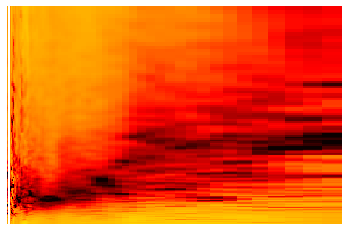

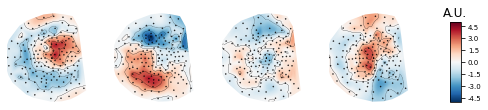

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_rate = np.int(raw.info['sfreq'])


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/numpy/lib/function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi
/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/emd/utils.py:297: RuntimeWarning: invalid value encountered in remainder
  phases = (IP) % (ncycles * 2 * np.pi)


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:89: RuntimeWarning: Mean of empty slice
  sholo_m = np.squeeze(np.nanmean(sholo_temp, axis = 0))
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


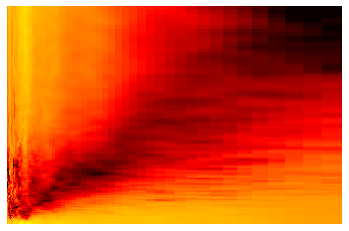

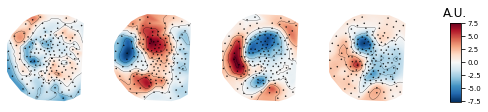

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_rate = np.int(raw.info['sfreq'])


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/numpy/lib/function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi
/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/emd/utils.py:297: RuntimeWarning: invalid value encountered in remainder
  phases = (IP) % (ncycles * 2 * np.pi)


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:89: RuntimeWarning: Mean of empty slice
  sholo_m = np.squeeze(np.nanmean(sholo_temp, axis = 0))
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


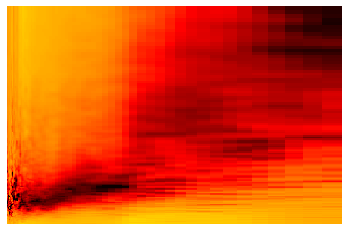

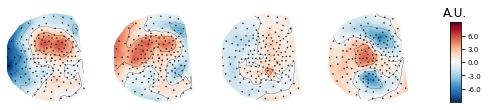

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_rate = np.int(raw.info['sfreq'])


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/numpy/lib/function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi
/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/emd/utils.py:297: RuntimeWarning: invalid value encountered in remainder
  phases = (IP) % (ncycles * 2 * np.pi)


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:89: RuntimeWarning: Mean of empty slice
  sholo_m = np.squeeze(np.nanmean(sholo_temp, axis = 0))
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


no id 6


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


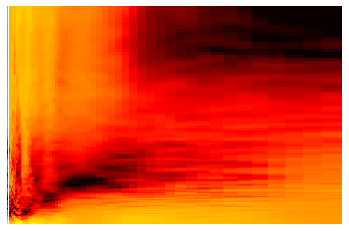

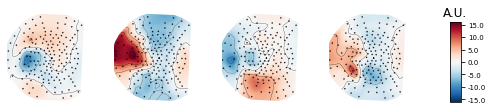

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_rate = np.int(raw.info['sfreq'])


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/numpy/lib/function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi
/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/emd/utils.py:297: RuntimeWarning: invalid value encountered in remainder
  phases = (IP) % (ncycles * 2 * np.pi)


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:89: RuntimeWarning: Mean of empty slice
  sholo_m = np.squeeze(np.nanmean(sholo_temp, axis = 0))
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


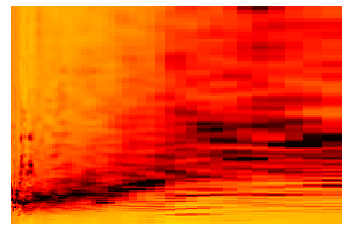

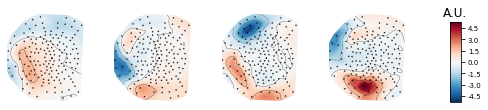

 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_rate = np.int(raw.info['sfreq'])


no id 8


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


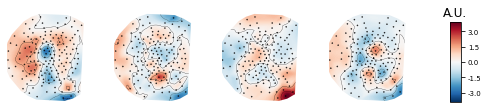

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_rate = np.int(raw.info['sfreq'])


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/numpy/lib/function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi
/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/emd/utils.py:297: RuntimeWarning: invalid value encountered in remainder
  phases = (IP) % (ncycles * 2 * np.pi)


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:89: RuntimeWarning: Mean of empty slice
  sholo_m = np.squeeze(np.nanmean(sholo_temp, axis = 0))
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


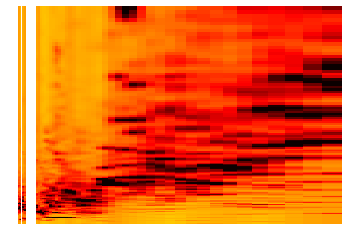

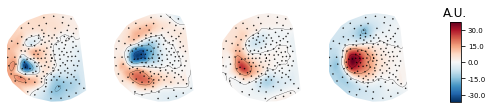

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_rate = np.int(raw.info['sfreq'])


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/numpy/lib/function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi
/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/emd/utils.py:297: RuntimeWarning: invalid value encountered in remainder
  phases = (IP) % (ncycles * 2 * np.pi)


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:89: RuntimeWarning: Mean of empty slice
  sholo_m = np.squeeze(np.nanmean(sholo_temp, axis = 0))
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


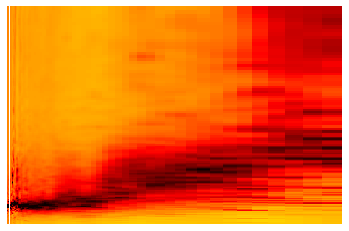

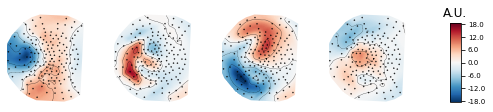

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_rate = np.int(raw.info['sfreq'])


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/numpy/lib/function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi
/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/emd/utils.py:297: RuntimeWarning: invalid value encountered in remainder
  phases = (IP) % (ncycles * 2 * np.pi)


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:89: RuntimeWarning: Mean of empty slice
  sholo_m = np.squeeze(np.nanmean(sholo_temp, axis = 0))
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


no id 12


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


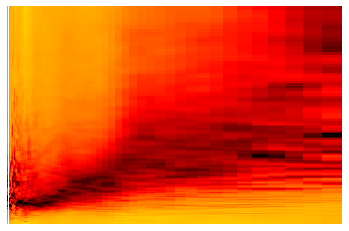

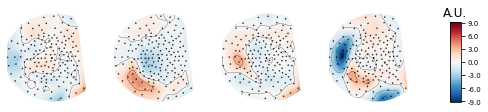

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_rate = np.int(raw.info['sfreq'])


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/numpy/lib/function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi
/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/emd/utils.py:297: RuntimeWarning: invalid value encountered in remainder
  phases = (IP) % (ncycles * 2 * np.pi)


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:89: RuntimeWarning: Mean of empty slice
  sholo_m = np.squeeze(np.nanmean(sholo_temp, axis = 0))
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


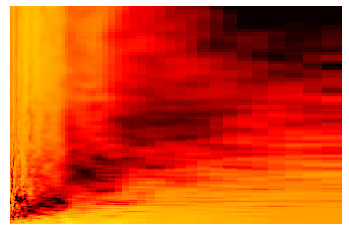

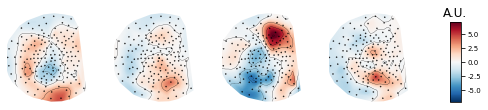

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_rate = np.int(raw.info['sfreq'])


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/numpy/lib/function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi
/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/emd/utils.py:297: RuntimeWarning: invalid value encountered in remainder
  phases = (IP) % (ncycles * 2 * np.pi)


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:89: RuntimeWarning: Mean of empty slice
  sholo_m = np.squeeze(np.nanmean(sholo_temp, axis = 0))
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


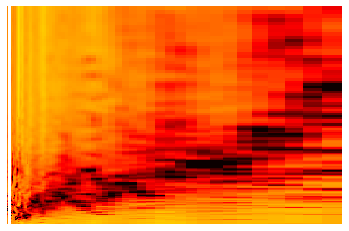

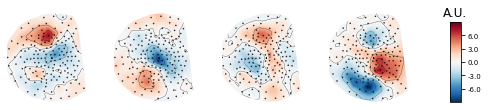

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_rate = np.int(raw.info['sfreq'])


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/numpy/lib/function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi
/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/emd/utils.py:297: RuntimeWarning: invalid value encountered in remainder
  phases = (IP) % (ncycles * 2 * np.pi)


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:89: RuntimeWarning: Mean of empty slice
  sholo_m = np.squeeze(np.nanmean(sholo_temp, axis = 0))
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


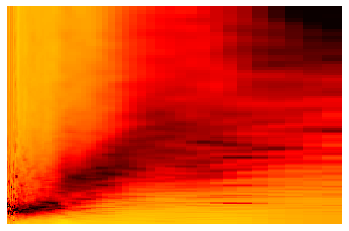

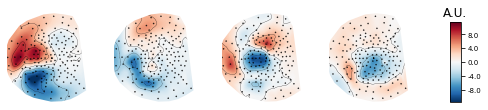

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_rate = np.int(raw.info['sfreq'])


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/numpy/lib/function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi
/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/emd/utils.py:297: RuntimeWarning: invalid value encountered in remainder
  phases = (IP) % (ncycles * 2 * np.pi)


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


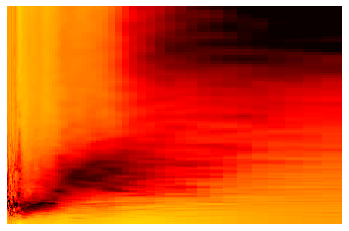

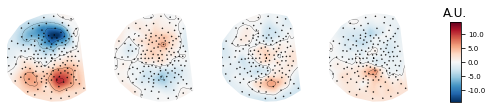

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_rate = np.int(raw.info['sfreq'])


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:89: RuntimeWarning: Mean of empty slice
  sholo_m = np.squeeze(np.nanmean(sholo_temp, axis = 0))
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


no id 18


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


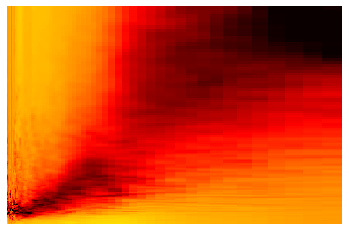

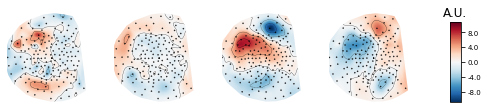

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_rate = np.int(raw.info['sfreq'])


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/numpy/lib/function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi
/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/emd/utils.py:297: RuntimeWarning: invalid value encountered in remainder
  phases = (IP) % (ncycles * 2 * np.pi)


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:89: RuntimeWarning: Mean of empty slice
  sholo_m = np.squeeze(np.nanmean(sholo_temp, axis = 0))
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


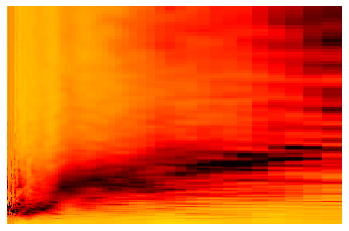

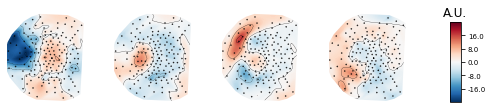

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_rate = np.int(raw.info['sfreq'])


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/numpy/lib/function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi
/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/emd/utils.py:297: RuntimeWarning: invalid value encountered in remainder
  phases = (IP) % (ncycles * 2 * np.pi)


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:89: RuntimeWarning: Mean of empty slice
  sholo_m = np.squeeze(np.nanmean(sholo_temp, axis = 0))
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


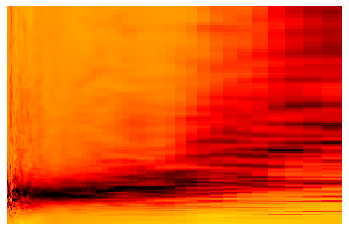

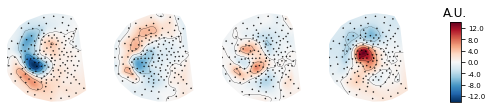

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_rate = np.int(raw.info['sfreq'])


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/numpy/lib/function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi
/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/emd/utils.py:297: RuntimeWarning: invalid value encountered in remainder
  phases = (IP) % (ncycles * 2 * np.pi)


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:89: RuntimeWarning: Mean of empty slice
  sholo_m = np.squeeze(np.nanmean(sholo_temp, axis = 0))
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


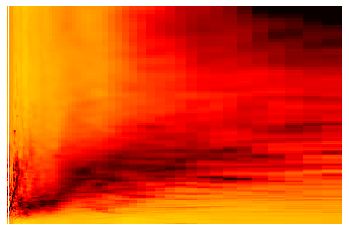

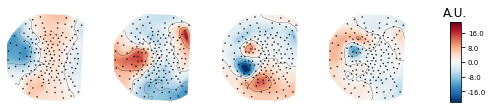

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_rate = np.int(raw.info['sfreq'])


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/numpy/lib/function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi
/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/emd/utils.py:297: RuntimeWarning: invalid value encountered in remainder
  phases = (IP) % (ncycles * 2 * np.pi)


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:89: RuntimeWarning: Mean of empty slice
  sholo_m = np.squeeze(np.nanmean(sholo_temp, axis = 0))
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


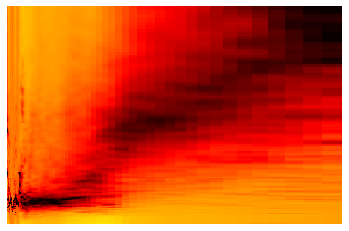

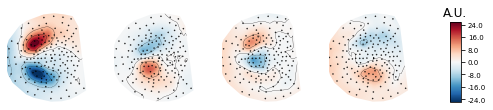

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_rate = np.int(raw.info['sfreq'])


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
no id 23


/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/numpy/lib/function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi
/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/emd/utils.py:297: RuntimeWarning: invalid value encountered in remainder
  phases = (IP) % (ncycles * 2 * np.pi)
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


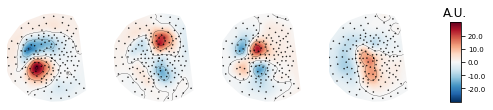

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_rate = np.int(raw.info['sfreq'])


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/numpy/lib/function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi
/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/emd/utils.py:297: RuntimeWarning: invalid value encountered in remainder
  phases = (IP) % (ncycles * 2 * np.pi)


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:89: RuntimeWarning: Mean of empty slice
  sholo_m = np.squeeze(np.nanmean(sholo_temp, axis = 0))
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


no id 25


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


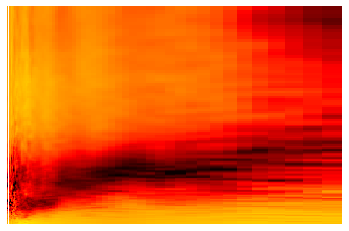

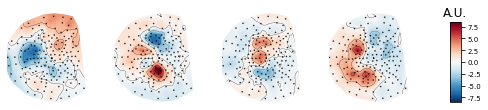

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_rate = np.int(raw.info['sfreq'])


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/numpy/lib/function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi
/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/emd/utils.py:297: RuntimeWarning: invalid value encountered in remainder
  phases = (IP) % (ncycles * 2 * np.pi)


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:89: RuntimeWarning: Mean of empty slice
  sholo_m = np.squeeze(np.nanmean(sholo_temp, axis = 0))
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


no id 27


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


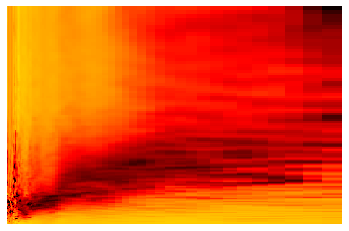

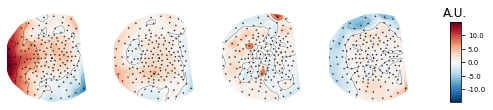

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_rate = np.int(raw.info['sfreq'])


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/numpy/lib/function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi
/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/emd/utils.py:297: RuntimeWarning: invalid value encountered in remainder
  phases = (IP) % (ncycles * 2 * np.pi)


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:89: RuntimeWarning: Mean of empty slice
  sholo_m = np.squeeze(np.nanmean(sholo_temp, axis = 0))
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:40: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


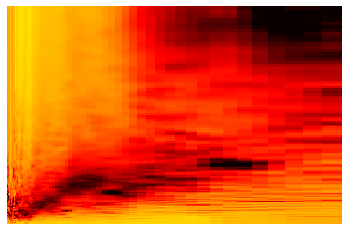

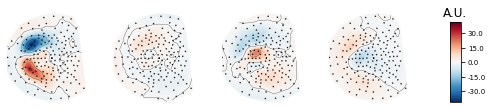

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_rate = np.int(raw.info['sfreq'])


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/numpy/lib/function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi
/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/emd/utils.py:297: RuntimeWarning: invalid value encountered in remainder
  phases = (IP) % (ncycles * 2 * np.pi)


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/2039183779.py:89: RuntimeWarning: Mean of empty slice
  sholo_m = np.squeeze(np.nanmean(sholo_temp, axis = 0))


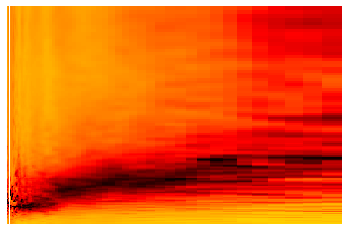

In [10]:
group = 'dementia'
path = '/Users/kevinhsu/Documents/D/00_datasets/biomag_2022/holo/train/m/'

for s in range(29):
    try:
        s += 1
        filename = 'de_hokuto_%s%d-raw.fif'%(group, s)

        sholo_m, fam, fcarrier = get_holo_trl(filename)

        fig, ax = plt.subplots()
        ax.pcolormesh(fam, fcarrier, stats.zscore(sholo_m), cmap='hot_r', shading='nearest', vmin = -3, vmax = 3)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)



        filename = 'hokuto_%s%d'%(group, s)

        fig_fname = path + filename + '-holo.png'
        fig.savefig(fig_fname, bbox_inches='tight')
    except:
        print('no id %d'%s)
    pass

/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/3434151881.py:17: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/3434151881.py:17: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


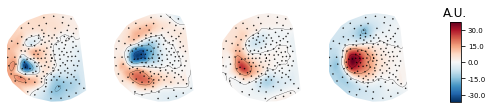

In [56]:
    raw=mne.io.read_raw_fif('de_hokuto_dementia10-raw.fif')
    # find alpha
    freqs_sig = 9, 12
    freqs_noise = 8, 13

    epochs = mne.make_fixed_length_epochs(raw, duration=2, preload=False)
    epochs.drop_bad(reject = dict(mag=3e-12))      # unit: T (magnetometers)

    ssd = SSD(info=raw.info,
              reg='oas',
              sort_by_spectral_ratio=False,  # False for purpose of example.
              n_components = 5,
              filt_params_signal=dict(l_freq=freqs_sig[0], h_freq=freqs_sig[1],
                                      l_trans_bandwidth=1, h_trans_bandwidth=1),
              filt_params_noise=dict(l_freq=freqs_noise[0], h_freq=freqs_noise[1],
                                     l_trans_bandwidth=1, h_trans_bandwidth=1))
    ssd.fit(X=epochs.get_data())

    pattern = mne.EvokedArray(data=ssd.patterns_[:4].T,
                              info=ssd.info)
    pattern.plot_topomap(units=dict(mag='A.U.'), time_format='')

    idx = np.argmax(np.abs(ssd.patterns_[0]))

In [61]:
epochs

Number of events,144
Events,1: 144
Time range,0.000 – 1.998 sec
Baseline,off


In [62]:
    idx = np.argmax(np.abs(ssd.patterns_[1]))
    name_ = raw.info['ch_names'][idx]
    epochs.load_data()
    x = epochs.copy().pick_channels([name_]).get_data()
    x = np.squeeze(x) * 1e+15
    x.shape

    n_trl = epochs.get_data().shape[0]
    sholo_temp = np.zeros((n_trl, 256, 128))

    sample_rate = np.int(raw.info['sfreq'])
   

    # Carrier frequency histogram definition
    carrier_hist = (1, 100, 256, 'log')
    # AM frequency histogram definition
    am_hist = (1e-2, 32, 128, 'log')

    for n in range(n_trl):
        config = emd.sift.get_config('mask_sift')
        config['max_imfs'] = 7
        config['mask_freqs'] = 50/sample_rate
        config['mask_amp_mode'] = 'ratio_sig'
        config['imf_opts/sd_thresh'] = 0.05
        imf = emd.sift.mask_sift(x[n], **config)
        IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')
        masks = np.array([25/2**ii for ii in range(12)])/sample_rate
        config = emd.sift.get_config('mask_sift')
        config['mask_amp_mode'] = 'ratio_sig'
        config['mask_amp'] = 2
        config['max_imfs'] = 5
        config['imf_opts/sd_thresh'] = 0.05
        config['envelope_opts/interp_method'] = 'mono_pchip'

        # Sift the first 5 first level IMFs
        imf2 = emd.sift.mask_sift_second_layer(IA, masks, sift_args=config)

        IP2, IF2, IA2 = emd.spectra.frequency_transform(imf2, sample_rate, 'nht')
        fcarrier, fam, holo = emd.spectra.holospectrum(IF[:,0:6], IF2[:,0:6,:], IA2[:,0:6,:], carrier_hist, am_hist)
        sholo = ndimage.gaussian_filter(holo, 1)

        sholo_temp[n] = sholo
        pass

    sholo_m = np.squeeze(np.nanmean(sholo_temp, axis = 0))

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_66414/4130205028.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_rate = np.int(raw.info['sfreq'])


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/numpy/lib/function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi
/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/emd/utils.py:297: RuntimeWarning: invalid value encountered in remainder
  phases = (IP) % (ncycles * 2 * np.pi)


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

ValueError: invalid entry in coordinates array

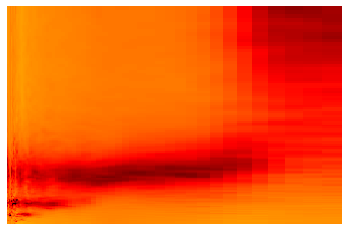

In [63]:
fig, ax = plt.subplots()
ax.pcolormesh(fam, fcarrier, stats.zscore(sholo_m), cmap='hot_r', shading='nearest', vmin = -5, vmax = 5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


In [59]:
?emd.plotting.plot_imfs

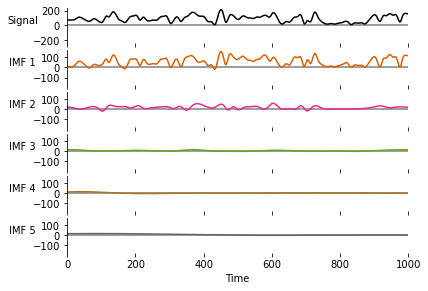

In [64]:
emd.plotting.plot_imfs(IA2[:,0,:], scale_y=True, cmap=True)

ValueError: Axis limits cannot be NaN or Inf

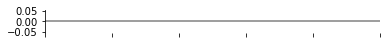

In [69]:
emd.plotting.plot_imfs(IA, scale_y=True, cmap=True)

In [66]:
IA.mean(axis=0).round(2)

array([ 73.35,  91.75, 312.7 ,  64.85,  68.84,    nan, -78.68])

In [70]:
np.std(IA[:,2]).round(3)

148.888

In [44]:
np.mean(IA[:,2]).round(3)

147.733

In [73]:
IF.mean(axis=0).round(0)

array([104.,  26.,   9.,   5.,   3.,   1.,  -0.])

In [75]:
IF.std(axis=0).round(0)

array([56., 19.,  3.,  3.,  1.,  0.,  1.])

In [77]:
IF2[:,0,:].mean(axis=0).round(2)

array([42.74, 16.95,  6.5 ,  3.01,  0.98])

In [78]:
IF2[:,0,:].std(axis=0).round(2)

array([19.33,  9.49,  4.36,  1.35,  3.92])

In [79]:
IF2[:,1,:].mean(axis=0).round(2)

array([14.05,  6.92,  2.5 ,  0.9 ,  0.41])

In [80]:
IF2[:,2,:].mean(axis=0).round(2)

array([ 3.42,  2.93,  1.44, -0.04, -0.05])

In [54]:
IF2[:,3,:].mean(axis=0).round(2)

array([ 2.42,  1.49, -0.05,  0.45,  0.  ])